In [1]:
!pip install torchinfo

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import glob
from tqdm import tqdm
import numpy as np
from google.colab import files

import torch
import torchvision
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, Subset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchinfo import summary

from matplotlib import pyplot as plt
from PIL import Image

In [4]:
%cd drive/MyDrive/Model/notebook/py
!ls

/content/drive/MyDrive/Model/notebook/py
config.py  __pycache__	results  runs  Training.py  vae.py


In [5]:
from Training import training_and_testing, loss_function
from vae import NeuralNet as nnet
import config as CFG

In [6]:
def rotate_images(image):
    # 이미지를 0도, 90도, 180도, 270도로 회전시키는 함수
    images = []
    for angle in [0, 90, 180, 270]:
        rotated_image = TF.rotate(image, angle)
        images.append(rotated_image)
    return images

def gauss_noise(image_tensor, sigma=0.05):
    # 이미지에 가우시안 노이즈를 추가하는 함수
    noise = torch.randn(image_tensor.size()) * sigma
    noisy_image = image_tensor + noise
    noisy_image = torch.clamp(noisy_image, 0, 1)
    return noisy_image


class VAECustomDataset(Dataset):
    def __init__(self, file_paths, transform=None, gauss_sigma=0.05):
        # 데이터셋 초기화
        self.file_paths = file_paths
        self.transform = transform
        self.gauss_sigma = gauss_sigma

    def __len__(self):
        # 데이터셋의 길이를 반환
        return len(self.file_paths)

    def __getitem__(self, idx):
        # 주어진 인덱스에 해당하는 데이터를 반환
        image = Image.open(self.file_paths[idx])
        if self.transform:
            # 변환이 주어진 경우
            original_image = self.transform(image)  # 원본 이미지 변환
            noisy_image = gauss_noise(original_image, self.gauss_sigma)  # 노이즈 추가 이미지 생성
            images = rotate_images(image)  # 회전 이미지 생성
            transformed_images = [self.transform(img) for img in images]  # 회전 이미지를 변환
            noisy_images = [gauss_noise(img, self.gauss_sigma) for img in transformed_images]  # 회전된 이미지에 노이즈 추가
            return original_image, noisy_image, transformed_images, noisy_images
        else:
            # 변환이 주어지지 않은 경우 원본 이미지 반환
            return image

In [7]:
trainset = torchvision.datasets.MNIST(root=r'/content/drive/MyDrive/Model/pre_data', train=True, download=True,
                                        transform=CFG.transform_pre)
indices = [i for i, target in enumerate(trainset.targets) if target == 0]
subset_0_class = Subset(trainset, indices)

train_loader = DataLoader(dataset=subset_0_class,batch_size=CFG.batch_size, shuffle=True,
                          num_workers=2)

In [8]:
for inputs, targets in train_loader:
    print(f"Batch inputs shape: {inputs.shape}")
    print(f"Batch targets: {targets}")
    break

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Batch inputs shape: torch.Size([32, 1, 480, 480])
Batch targets: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])


Labels: 0 0 0 0 0


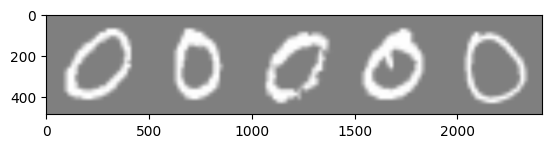

In [9]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(train_loader)
images, labels = next(dataiter)

num_images_to_show = 5
print('Labels:', ' '.join(f'{labels[j].item()}' for j in range(num_images_to_show)))

imshow(torchvision.utils.make_grid(images[:num_images_to_show]))

In [10]:
folder = r'/content/drive/MyDrive/Model/data/Normal'
file_path = glob.glob(os.path.join(folder, "*.jpg"))

In [11]:
train_size = int(0.8 * len(file_path))
test_size = len(file_path) - train_size

train_paths, test_paths = random_split(file_path, [train_size, test_size])

train_dataset = VAECustomDataset(file_paths=train_paths, transform=CFG.transform)
test_dataset = VAECustomDataset(file_paths=test_paths, transform=CFG.transform)

In [13]:
neuralnet = nnet(height=CFG.height, width=CFG.width, channel=CFG.channel,
                 device=CFG.device, ngpu=CFG.ngpu)

The number of parameters: 195025.0000


In [14]:
summary(neuralnet.encoder, input_size=(32, 1, 480, 480), device='cpu')

Layer (type:depth-idx)                   Output Shape              Param #
Encoder                                  [32, 20, 15, 15]          --
├─Sequential: 1-1                        [32, 64, 15, 15]          --
│    └─Conv2d: 2-1                       [32, 16, 480, 480]        416
│    └─ELU: 2-2                          [32, 16, 480, 480]        --
│    └─Conv2d: 2-3                       [32, 16, 480, 480]        6,416
│    └─ELU: 2-4                          [32, 16, 480, 480]        --
│    └─MaxPool2d: 2-5                    [32, 16, 240, 240]        --
│    └─Conv2d: 2-6                       [32, 32, 240, 240]        4,640
│    └─ELU: 2-7                          [32, 32, 240, 240]        --
│    └─Conv2d: 2-8                       [32, 32, 240, 240]        9,248
│    └─ELU: 2-9                          [32, 32, 240, 240]        --
│    └─MaxPool2d: 2-10                   [32, 32, 60, 60]          --
│    └─Conv2d: 2-11                      [32, 64, 60, 60]          18,496
│

In [15]:
summary(neuralnet.decoder, input_size=(32, 20, 15, 15), device='cpu')

Layer (type:depth-idx)                   Output Shape              Param #
Decoder                                  [32, 1, 480, 480]         --
├─Sequential: 1-1                        [32, 20, 15, 15]          --
│    └─Conv2d: 2-1                       [32, 20, 15, 15]          420
│    └─ELU: 2-2                          [32, 20, 15, 15]          --
├─Sequential: 1-2                        [32, 1, 480, 480]         --
│    └─Conv2d: 2-3                       [32, 20, 15, 15]          3,620
│    └─ELU: 2-4                          [32, 20, 15, 15]          --
│    └─Conv2d: 2-5                       [32, 64, 15, 15]          11,584
│    └─ELU: 2-6                          [32, 64, 15, 15]          --
│    └─Upsample: 2-7                     [32, 64, 60, 60]          --
│    └─Conv2d: 2-8                       [32, 64, 60, 60]          36,928
│    └─ELU: 2-9                          [32, 64, 60, 60]          --
│    └─Conv2d: 2-10                      [32, 32, 60, 60]          18,464

In [16]:
def pretrain(neuralnet, train_loader, epochs):
    neuralnet.train(mode=True)
    best_loss = float('inf')  # Initialize best loss to a very high value

    for epoch in range(epochs):
        num_batches = len(train_loader)

        for i, (inputs, _) in enumerate(train_loader):
            input = inputs.to(CFG.device)
            enc, mu, sigma = neuralnet.encoder(input)
            x_hat = neuralnet.decoder(enc)
            loss, restore_error, kl_divergence = loss_function(
                x=input, x_hat=x_hat, mu=mu, sigma=sigma
            )
            neuralnet.optimizer.zero_grad()
            loss.backward()
            neuralnet.optimizer.step()

            # Check if the current batch loss is the best we've seen so far
            if loss.item() < best_loss:
                best_loss = loss.item()
                print(f'New best model found at epoch {epoch + 1}, batch {i + 1}, saving model.')
                torch.save(neuralnet.encoder.state_dict(), 'vae_encoder_best.pth')
                torch.save(neuralnet.decoder.state_dict(), 'vae_decoder_best.pth')

            if (i + 1) % 10 == 0:
                print(f'Epoch [{epoch + 1}/{epochs}], Step [{i + 1}/{num_batches}], Loss: {loss.item():.4f}, '
                      f'Restore_error: {restore_error:.4f}, KL-Divergence: {kl_divergence:.4f}')


In [17]:
neuralnet.to(CFG.device)
weight_device = neuralnet.encoder.encoder_conv[0].weight.device
print("Weight tensor of device:", weight_device)

Weight tensor of device: cuda:0


In [18]:
 pretrain(neuralnet=neuralnet, train_loader=train_loader, epochs=1)

New best model found at epoch 1, batch 1, saving model.
New best model found at epoch 1, batch 2, saving model.
New best model found at epoch 1, batch 4, saving model.
New best model found at epoch 1, batch 5, saving model.
New best model found at epoch 1, batch 9, saving model.
Epoch [1/1], Step [10/186], Loss: 0.1146, Restore_error: 0.1118, KL-Divergence: 0.0028
New best model found at epoch 1, batch 11, saving model.
New best model found at epoch 1, batch 14, saving model.
New best model found at epoch 1, batch 18, saving model.
Epoch [1/1], Step [20/186], Loss: 0.1018, Restore_error: 0.1008, KL-Divergence: 0.0010
New best model found at epoch 1, batch 24, saving model.
New best model found at epoch 1, batch 27, saving model.
New best model found at epoch 1, batch 28, saving model.
New best model found at epoch 1, batch 29, saving model.
Epoch [1/1], Step [30/186], Loss: 0.1013, Restore_error: 0.1006, KL-Divergence: 0.0007
New best model found at epoch 1, batch 35, saving model.
New

The number of parameters: 195025.0000
Original Image:


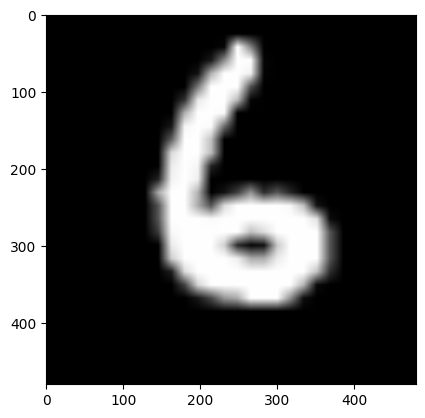

Reconstructed Image:


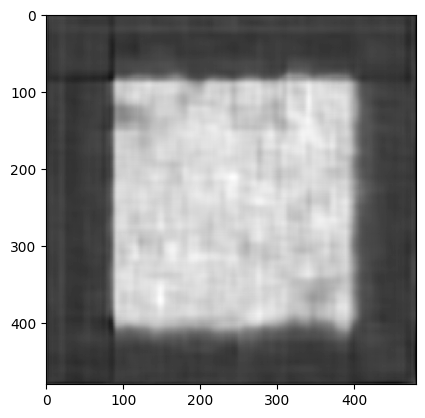

In [28]:
def load_pretrained_model(encoder_path, decoder_path, device):
    neuralnet = nnet(height=CFG.height, width=CFG.width, channel=CFG.channel, device=CFG.device, ngpu=CFG.ngpu)
    # neuralnet.encoder.load_state_dict(torch.load(encoder_path))
    neuralnet.decoder.load_state_dict(torch.load(decoder_path))
    return neuralnet

# 이미지 보여주는 함수
def show_image(img):
    img = img.squeeze()
    img = img.detach().cpu().numpy()
    plt.imshow(img, cmap='gray')
    plt.show()

vae = load_pretrained_model('/content/drive/MyDrive/Model/notebook/py/vae_encoder_best.pth', '/content/drive/MyDrive/Model/notebook/py/vae_decoder_best.pth', CFG.device)
vae.encoder.eval()
vae.decoder.eval()

# MNIST 데이터셋에서 0번 클래스가 아닌 다른 클래스의 이미지를 로드
mnist = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=CFG.transform)
loader = DataLoader(mnist, batch_size=1, shuffle=True)

# 0번 클래스가 아닌 이미지를 찾기
for img, label in loader:
    if label.item() != 0:
        img = img.to(CFG.device)
        break

# 인코딩 및 디코딩
with torch.no_grad():
    enc, mu, sigma = vae.encoder(img)
    reconstructed_img = vae.decoder(enc)

# 원본 이미지와 재구성된 이미지 출력
print("Original Image:")
show_image(img)

print("Reconstructed Image:")
show_image(reconstructed_img)